In [1]:
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy import units as u
import importlib
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import sys
sys.path.append('../')

from modules import aperturephotometry as aph
from modules import tesscut_interface as tci


importlib.reload(aph)
importlib.reload(tci)

# %matplotlib qt
# %matplotlib inline

<module 'modules.tesscut_interface' from '/home/lukas/github/MasterThesisComputerScience/TPF_video_prediction/demos/../modules/tesscut_interface.py'>

In [2]:
#define targets

# tesstr_path = f'../data/tess_transients.parquet'
# df_tesstr = pl.read_parquet(tesstr_path).filter(pl.col('#sector')==60)[:]
# display(df_tesstr)
# print(repr(df_tesstr.select(pl.col('ra','dec','name')).to_dicts()))

#control
save_tpfs = f'./data/'

#define targets
transients = [
    dict(coords=SkyCoord(327.16008333,-43.38001944, unit=u.deg), name='2018evo', sectors=[1],  period=1e8),
    # dict(coords=SkyCoord(315.03341667,-40.35859444, unit=u.deg), name='2018exc', sectors=[1],  period=1e8),
    # dict(coords=SkyCoord(313.47458333,-38.01559444, unit=u.deg), name='2018fgb', sectors=[1],  period=1e8),
    dict(coords=SkyCoord(342.82569167,-38.87439722, unit=u.deg), name='2018exg', sectors=[1],  period=1e8),
    dict(coords=SkyCoord(332.648,     -27.25016111, unit=u.deg), name='2018emt', sectors=[1],  period=1e8),
    dict(coords=SkyCoord(7258.67275,  66.856131,    unit=u.deg), name='2023ael', sectors=None, period=1e8), #extract all available sectors
]
rrlyr = [
    dict(coords=SkyCoord('19 25 27.9129605304 +42 47 03.693258204', frame='icrs', unit=(u.hourangle, u.deg)), name='RRLyr', sectors=[14,40],   period=0.5667732268824381),
    dict(coords=SkyCoord('14 16 36.5814789480 +42 21 35.712985824', frame='icrs', unit=(u.hourangle, u.deg)), name='TVBoo', sectors=[1,16,23], period=0.3125589785657776),
]

df_targets = pl.from_dicts(transients+rrlyr)
display(df_targets)


coords,name,sectors,period
object,str,list[i64],f64
"<SkyCoord (ICRS): (ra, dec) in deg (327.16008333, -43.38001944)>","""2018evo""",[1],1e8
"<SkyCoord (ICRS): (ra, dec) in deg (342.82569167, -38.87439722)>","""2018exg""",[1],1e8
"<SkyCoord (ICRS): (ra, dec) in deg (332.648, -27.25016111)>","""2018emt""",[1],1e8
"<SkyCoord (ICRS): (ra, dec) in deg (58.67275, 66.856131)>","""2023ael""",null,1e8
"<SkyCoord (ICRS): (ra, dec) in deg (291.366304, 42.78435924)>","""RRLyr""","[14, 40]",0.566773
"<SkyCoord (ICRS): (ra, dec) in deg (214.15242283, 42.35992027)>","""TVBoo""","[1, 16, 23]",0.312559


[ 1 28 68]
[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7d087b56d120>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7d087bca09d0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7d087bca08b0>]]
[0.] (1282, 15, 15)
[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7d087b5ce860>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7d087b56d5a0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7d087b56dd50>]]
[0.] (3464, 15, 15)
[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7d087b56e080>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7d087bca0850>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7d087bca0a60>]]
[0.] (11639, 15, 15)


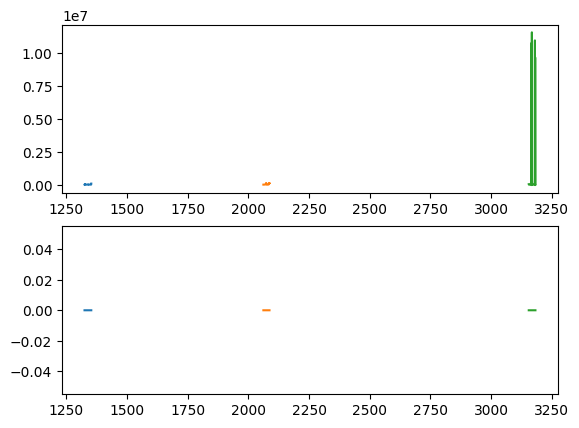

In [3]:
#TESTING BACKGROUND IMAGES
from astroquery.mast import Tesscut
import lightkurve as lk


plot_idx = 2
sectors = Tesscut.get_sectors(coordinates=df_targets['coords'][plot_idx])
sectors = sectors['sector'].value
print(sectors)




fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
for s in sectors:
    # hdul = lk.search_targetpixelfile(target=df_targets['coords'][plot_idx], mission='TESS', sector=s).download()
    hdul = Tesscut.get_cutouts(coordinates=df_targets['coords'][plot_idx], size=(15,15), sector=s)
    print(hdul)

    t = hdul[0][1].data.field('TIME')
    f = hdul[0][1].data.field('FLUX')
    f_bg = hdul[0][1].data.field('FLUX_BKG')

    print(np.unique(f_bg), f_bg.shape)

    ax1.plot(t%df_targets['period'][plot_idx], f.sum(axis=(1,2)))
    ax2.plot(t%df_targets['period'][plot_idx], f_bg.sum(axis=(1,2)))
plt.show()

In [4]:
importlib.reload(tci)

#load data
TCI = tci.TESScut_Interface(
    n_jobs=5,
    redownload=True,
    sleep=.5,
    verbose=1,
)

#download
hdulists = TCI.download(
    coordinates=df_targets['coords'],
    sectors=df_targets['sectors'],
    targ_ids=df_targets['name'],
    combine_sectors=True,       #combine all downloaded sectors into one array
    ffi_header_keys=['TELESCOP'],
    prim_header_keys=['TELESCOP', 'INSTRUME'],
    col_keys=['SECTOR','EXPOSURE'],
    n_jobs=None,
    savedir=save_tpfs,
    # savedir=None,             #don't save
    filenames=None,             #autogenerate
    verbose=None,
    parallel_kwargs=dict(backend='threading'),
    get_cutouts_kwargs=dict(size=[15,12], product='SPOC'),   #size=(ny,nx)
)

In [5]:
#in case you already have the files downloaded
from astropy.io import fits
hdulists = [fits.open(f'./{save_tpfs}{name}_tpfs.fits') for name in df_targets['name']]    #load in same order as input dataframe (and hence coords)
print(hdulists)
print(len(hdulists))

[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7d087b183d90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7d087b1a2ef0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7d087b1a2cb0>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7d08ac9f39a0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7d087b1a3610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7d087b1a3490>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7d08ac9f1e10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7d087b1a2e00>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7d087b1a3d90>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7d08ac9f1fc0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7d087b5cc700>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7d087bca0f70>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7d087b1a3d00>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7d087b1a3280>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7d087b1a3ca0>], [<as

In [6]:
tpfs        = [hdul[1].data.field('FLUX').copy() for hdul in hdulists]
tpfs_e      = [hdul[1].data.field('FLUX_ERR').copy() for hdul in hdulists]
tpfs_bg     = [hdul[1].data.field('FLUX_BKG').copy() for hdul in hdulists]
tpfs_bg_e   = [hdul[1].data.field('FLUX_BKG_ERR').copy() for hdul in hdulists]
times       = [hdul[1].data.field('TIME').copy() for hdul in hdulists]
sectors     = [hdul[1].data.field('SECTOR').copy() for hdul in hdulists]

print(len(tpfs))

6


## Using Nearby Constant Reference Targets

### Extracting Reference Targets

In [7]:
#function to filter table of results
def filter_func(
    tab:Table
    ) -> Table:
    """
        - function to get relevant target out of nearby reference targets
    """
    
    #reference object with distance closest to the median of all distances
    filtered = tab[np.argsort(np.abs(tab['distance']-np.median(tab['distance'])))][-1:]
    # #reference object closest to science target
    # filtered = tab[np.argsort(tab['distance'])][-1:]
    # #reference object furthest from science target
    # filtered = tab[np.argsort(tab['distance'])][:1]
    # #all reference objects
    # filtered = tab

    return filtered


In [8]:
importlib.reload(aph)
#get reference frames
X_ref = []          #reference frames
X_ref_e = []        #uncertainties of reference frames
success_idxs = []   #indices where extraction was successful
fail_idxs = []      #indices where extraction failed
for idx, (c, s, tpf) in enumerate(zip(df_targets['coords'], sectors, tpfs)):
    
    #get table of potential reference objects
    tab_ref = aph.get_reference_objects(
        coords=c,
        radius=10*21/3600,  #n*TESS pixels
        verbose=1,
    )

    #extract tpfs for reference objects
    if tab_ref is not None:
                
        #obtain coordinates
        tab_ref = filter_func(tab_ref)
        ra, dec = tab_ref['ra'].quantity, tab_ref['dec'].quantity
        targ_id = tab_ref['main_id']

        #download frames
        TI = tci.TESScut_Interface(
            n_jobs=1,
            redownload=True,
            verbose=1,
        )
        Xi_ref = TI.download(
            coordinates=SkyCoord(ra, dec),
            sectors=[sorted(np.unique(s))]*len(tab_ref),
            targ_ids=targ_id,
            combine_sectors=True,
            ffi_header_keys=None,
            prim_header_keys=None,
            col_keys=['SECTOR'],
            n_jobs=None,
            filenames=None,
            savedir=None,   #dont save
            verbose=None,
            parallel_kwargs=None,
            get_cutouts_kwargs=dict(size=tpf.shape[1:])
        )

        X_ref.append(Xi_ref[0][1].data.field('FLUX'))
        X_ref_e.append(Xi_ref[0][1].data.field('FLUX_ERR'))
        success_idxs.append(idx)
        # fig, axs, anim = TI.plot_result(X_ref[-1][0], func_animation_kwargs=dict(frames=np.arange(0,1000,4)))
        # # anim.save('./temp.png')
        # plt.show()
    else:
        X_ref.append(None)
        X_ref_e.append(None)
        fail_idxs.append(idx)



/home/lukas/venvs/thesisCS/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/lukas/venvs/thesisCS/lib/python3.10/site-packages/astroLuSt/monitoring/errorlogging.py:277: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df_errorlog = pd.concat([self.df_errorlog, df_temp])
/home/lukas/venvs/thesisCS/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/lukas/venvs/thesisCS/lib/python3.10/site-packages/astroLuSt/monitoring/errorlogging.py:277: FutureWarnin

WARNING(get_reference_objects()): WARNING: did not find any nearby constant stars for ra=332.648 deg, dec=-27.25016111 deg, radius=0.058333333333333334 deg. Consider increasing `radius` or choose a different method for background-correction. Returning `None` for that matter.


/home/lukas/venvs/thesisCS/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/lukas/venvs/thesisCS/lib/python3.10/site-packages/astroLuSt/monitoring/errorlogging.py:277: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df_errorlog = pd.concat([self.df_errorlog, df_temp])
/home/lukas/venvs/thesisCS/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/lukas/venvs/thesisCS/lib/python3.10/site-packages/astroLuSt/monitoring/errorlogging.py:277: FutureWarnin

WARNING(get_reference_objects()): WARNING: did not find any nearby constant stars for ra=214.15242282895 deg, dec=42.359920273840004 deg, radius=0.058333333333333334 deg. Consider increasing `radius` or choose a different method for background-correction. Returning `None` for that matter.


### Frame-Wise Differential Photometry

/home/lukas/venvs/thesisCS/lib/python3.10/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


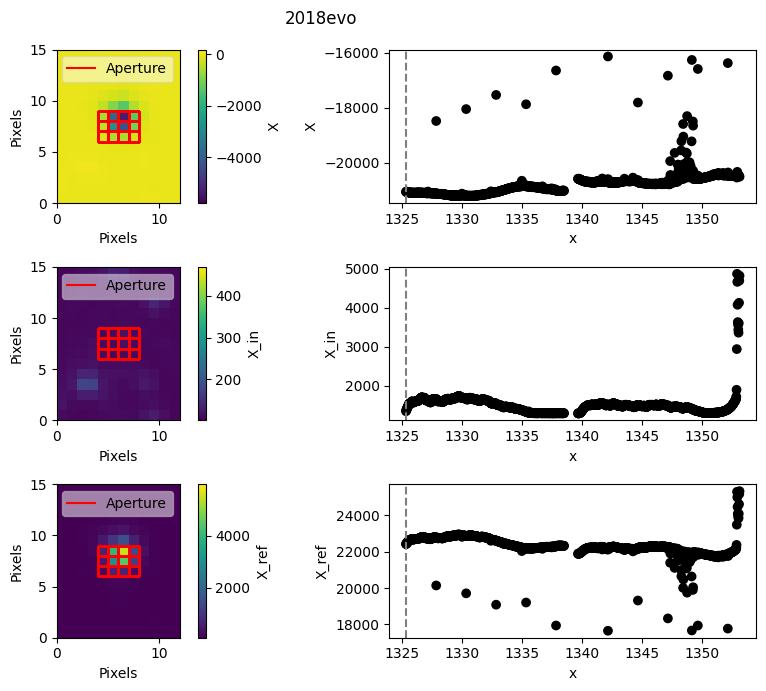

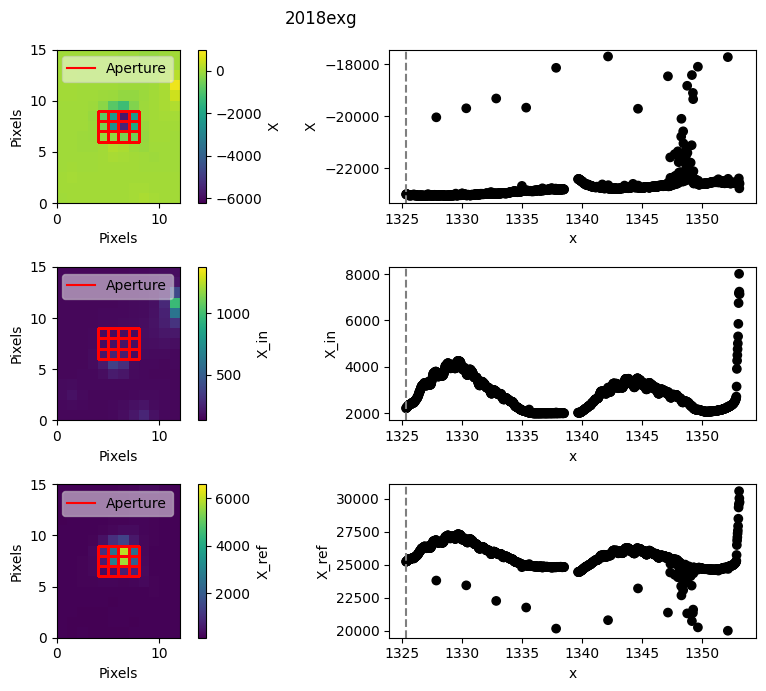

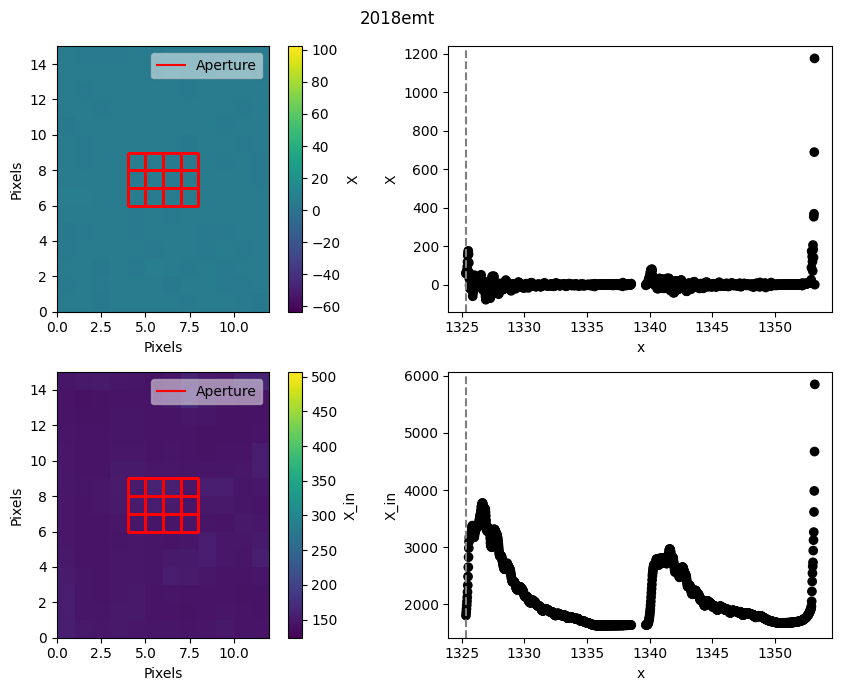

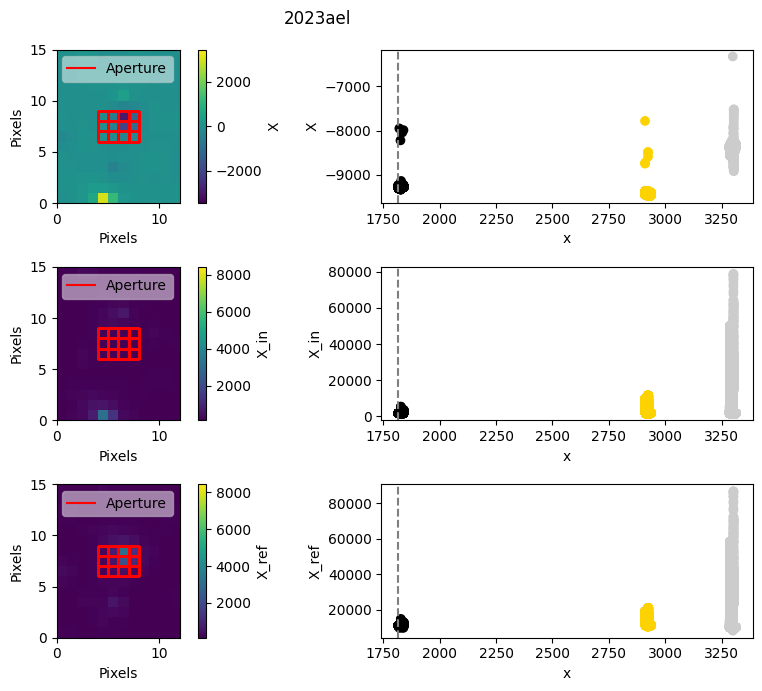

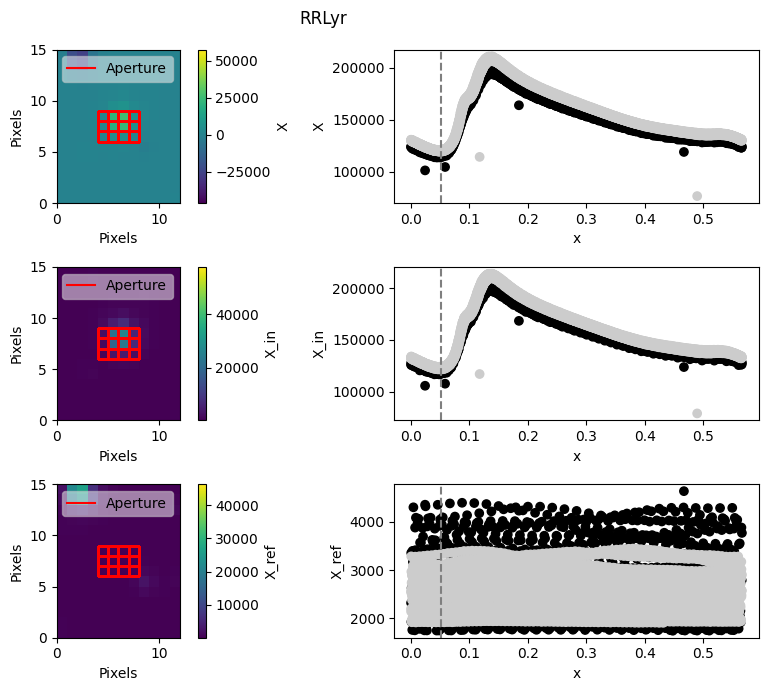

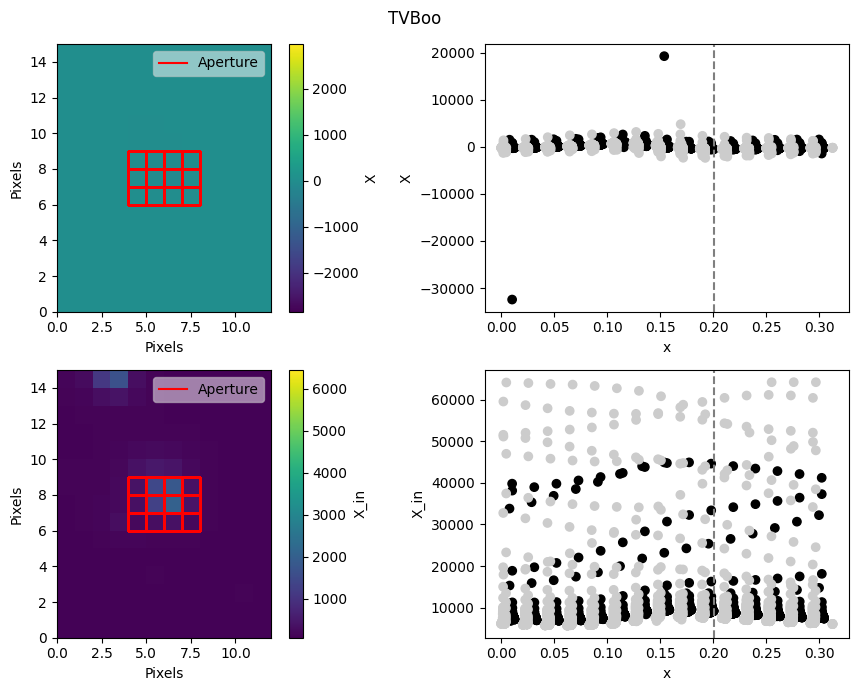

In [9]:
importlib.reload(aph)

#execute differential photometry
DPI = aph.DifferentialPhotometryImage(
    n_jobs=1,
    verbose=1,
)
DPI.fit(
    X=tpfs, y=None, X_ref=X_ref,
    X_e=tpfs_e, X_ref_e=X_ref_e,
    # X_ref=0,
    strategy='previous',
    n_jobs=None,
    verbose=None,
    strategy_kwargs=None,
    parallel_kwargs=None,
)
X_dp, X_dp_e = DPI.transform(X=tpfs, y=None)


for idx in range(0,len(X_dp)):
    #make sure X_dp matches shape requirements (relevant if no X_ref found and therefore `strategy="previous"` was used)
    if len(X_dp[idx]) != len(tpfs[idx]):
        X_dp_correction = np.empty((1,*X_dp[idx].shape[1:]))
        X_dp_correction[:,:,:] = np.nan
        X_dp[idx]   = np.append(X_dp[idx],   X_dp_correction, axis=0)
        X_dp_e[idx] = np.append(X_dp_e[idx], X_dp_correction, axis=0)
        

    fig = plt.figure(figsize=(9,7))
    fig.suptitle(df_targets['name'][idx])
    fig, axs, anim = DPI.plot_result(
        X=X_dp[idx], y=None, #X_e=X_dp_e[idx],
        X_in=tpfs[idx], #X_in_e=tpfs_e[idx],
        X_ref=X_ref[idx], #X_ref_e=X_ref_e[idx],
        x_vals=times[idx]%df_targets['period'][idx],
        aperture=2,
        fig=fig,
        animate=False,
        verbose=None,
        pcolormesh_kwargs=None,
        sctr_kwargs=dict(c=sectors[idx]),
        func_animation_kwargs=dict(frames=np.arange(0, X_dp[idx].shape[0], 50))
    )

    # if anim is not None: anim.save(f'./temp_{targnames[idx]}_diffphot.gif')



### Lightcurve Differential Photometry

In [10]:
#stuff where reference extraction was sucessful

X_ref_sucess    = [X_ref[i] for i in success_idxs]
X_ref_e_sucess  = [X_ref_e[i] for i in success_idxs]
tpfs_sucess     = [tpfs[i] for i in success_idxs]
tpfs_e_sucess   = [tpfs_e[i] for i in success_idxs]
times_sucess    = [times[i] for i in success_idxs]
sectors_sucess  = [sectors[i] for i in success_idxs]
periods_sucess  = [df_targets['period'][i] for i in success_idxs]


In [11]:
#get LCs for reference targets where extraction was possible
AP = aph.AperturePhotometry(n_jobs=1, verbose=0)

##reference targets
AP.fit(X=X_ref_sucess, y=None, X_e=X_ref_e_sucess, apertures=2)
X_ref_lcs, X_ref_lcs_e, X_ref_apertures = AP.transform()

#science targets
AP.fit(X=tpfs_sucess, y=None, X_e=tpfs_e_sucess, apertures=2)
tpfs_lcs, tpfs_lcs_e, tpfs_apertures = AP.transform()

# fig, axs, anim = AP.plot_result(
#     X=X_ref_lcs[0], X_e=X_ref_lcs_e[0],
#     X_in=X_ref[0],
#     aperture=X_ref_apertures[0]
# )
# plt.show()

#extract one single flux-series from LCs
X_ref_lcs   = [Xi[:,0].flatten() for Xi in X_ref_lcs]
tpfs_lcs    = [Xi[:,0].flatten() for Xi in tpfs_lcs]
X_ref_lcs_e = [Xi[:,0].flatten() for Xi in X_ref_lcs_e]
tpfs_lcs_e  = [Xi[:,0].flatten() for Xi in tpfs_lcs_e]



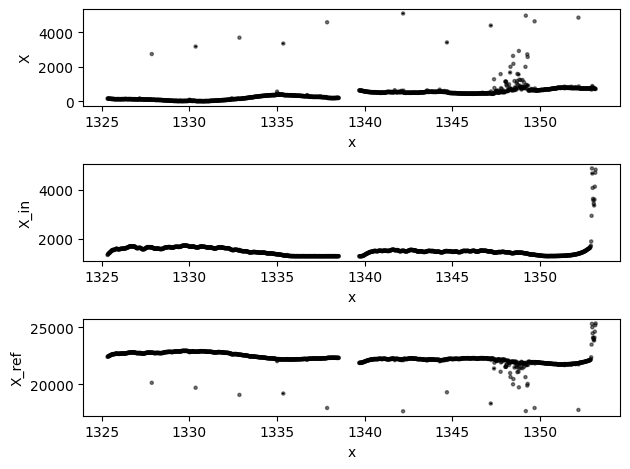

In [12]:
importlib.reload(aph)

#execute differential photometry
DPLC = aph.DifferentialPhotometryLC(
    n_jobs=5,
    verbose=1,
)
DPLC.fit(
    X=tpfs_lcs, y=None,
    X_ref=X_ref_lcs,
    X_e=tpfs_lcs_e, X_ref_e=X_ref_lcs_e,
    strategy=None,
    n_jobs=None,
    verbose=None,
    strategy_kwargs=None,
    parallel_kwargs=dict(backend='threading'),
)
X_dp, X_dp_e = DPLC.transform(X=None, y=None)

# for idx in range(0,len(X_dp)):
for idx in range(0,1):
    fig, axs = DPLC.plot_result(
        X=X_dp[idx]-X_dp[idx].min(), X_e=X_dp_e[idx],
        # X=X_dp[idx], X_e=X_dp_e[idx],
        X_in=tpfs_lcs[idx], X_in_e=tpfs_lcs_e[idx],
        X_ref=X_ref_lcs[idx], X_ref_e=X_ref_lcs_e[idx],
        x_vals=times_sucess[idx]%periods_sucess[idx],
        sctr_kwargs=dict(c=sectors_sucess[idx], alpha=0.5, s=5),
        errorbar_kwargs=None,
    )

plt.show()

## Sky-Ring Approach

### Get Apertures

1.0 1.0


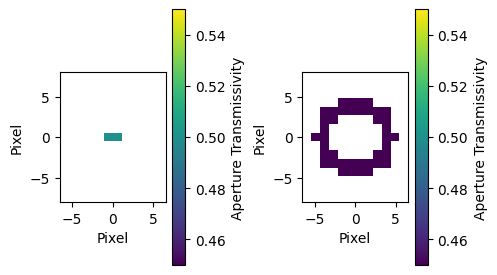

In [13]:
importlib.reload(aph)

#get apertures
AP = aph.Aperture(
    size=tpfs[0].shape[1:],
    npixels=1,  #normalize to 1 pixel
    outside=np.nan, #specify outside-aperture values
    position=None,
    verbose=0
)

ap_targ = AP.lp_aperture(radius=1, p=2, radius_inner=0)
ap_bg   = AP.lp_aperture(radius=5, p=2, radius_inner=3)

print(np.nansum(ap_targ), np.nansum(ap_bg))

fig = plt.figure(figsize=(5,3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig, axs = AP.plot_result(ap_targ,  ax=ax1, pcolormesh_kwargs=dict(vmin=np.nanmin(ap_targ), vmax=np.nanmax(ap_targ)))
fig, asx = AP.plot_result(ap_bg,    ax=ax2, pcolormesh_kwargs=dict(vmin=np.nanmin(ap_targ), vmax=np.nanmax(ap_targ)))
fig.tight_layout()
plt.show()

### Lightcurve Differential Photometry

In [14]:
importlib.reload(aph)
#apply aperture photometry

APH = aph.AperturePhotometry(n_jobs=1, verbose=0)

lcs_targ, lcs_targ_e, aps_targ  = APH.fit_transform(
    X=tpfs, X_e=tpfs_e,
    fit_kwargs=dict(apertures=[ap_targ]*len(tpfs))
)
lcs_bg, lcs_bg_e, aps_bg        = APH.fit_transform(
    X=tpfs, X_e=tpfs_e,
    # #sum sky-ring
    # fit_kwargs=dict(
    #     apertures=[ap_bg]*len(tpfs),
    #     reduce_func=None,
    # ),
    #median sky-ring
    fit_kwargs=dict(
        apertures=[ap_bg*np.isfinite(ap_bg).sum()]*len(tpfs),   
        reduce_func=lambda x, x_e, axis: (np.nanmedian(x, axis=axis), np.nanmax(x_e, axis=axis)),
    ),
)

# #plotting
# ##remove nan to enable setting alpha
# ap2plot_targ = aps_targ[0].copy()
# ap2plot_targ[np.isnan(ap2plot_targ)] = 0
# ap2plot_bg = aps_bg[0].copy()
# ap2plot_bg[np.isnan(ap2plot_bg)] = 0
# fig, axs, anim = APH.plot_result(X=lcs_targ[0], X_e=lcs_targ_e[0], X_in=tpfs[0],    aperture=ap2plot_targ, animate=False)
# fig, axs, anim = APH.plot_result(X=lcs_bg[0],   X_e=lcs_bg_e[0],   X_in=tpfs[0],    aperture=ap2plot_bg,   animate=False)

lcs_targ    = [lc[:,0].flatten() for lc in lcs_targ]
lcs_bg      = [lc[:,0].flatten() for lc in lcs_bg]
lcs_targ_e  = [lc[:,0].flatten() for lc in lcs_targ_e]
lcs_bg_e    = [lc[:,0].flatten() for lc in lcs_bg_e]


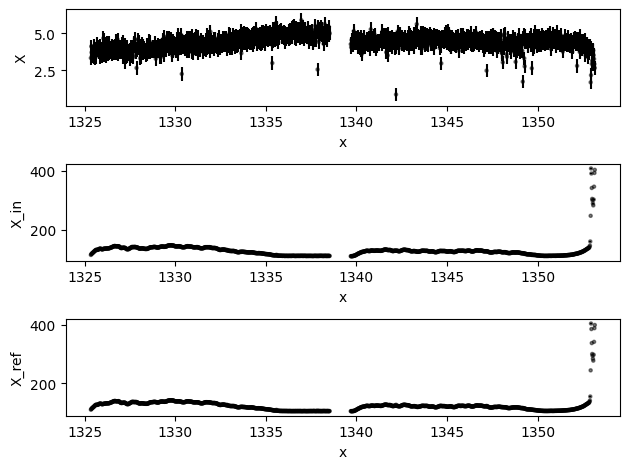

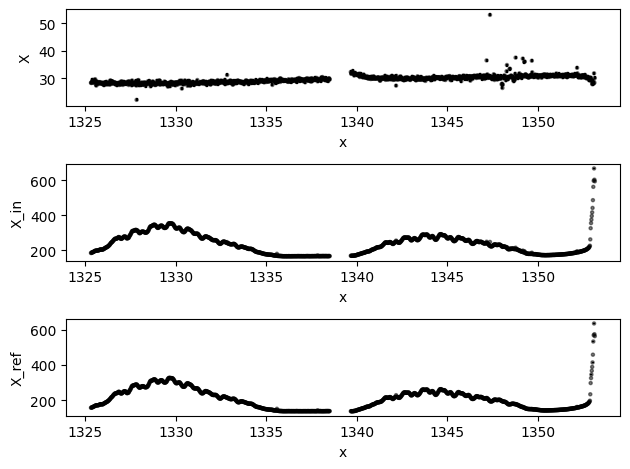

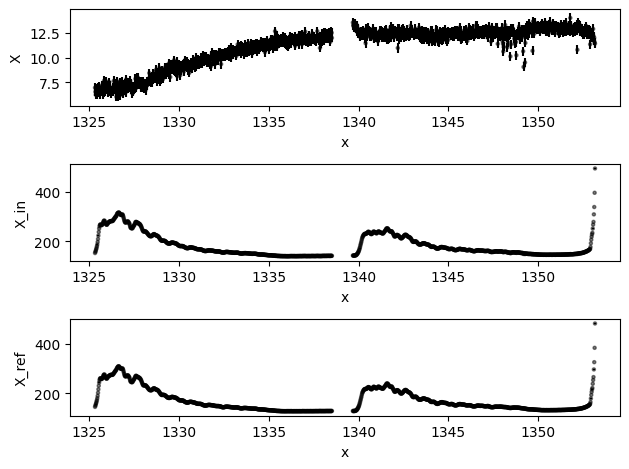

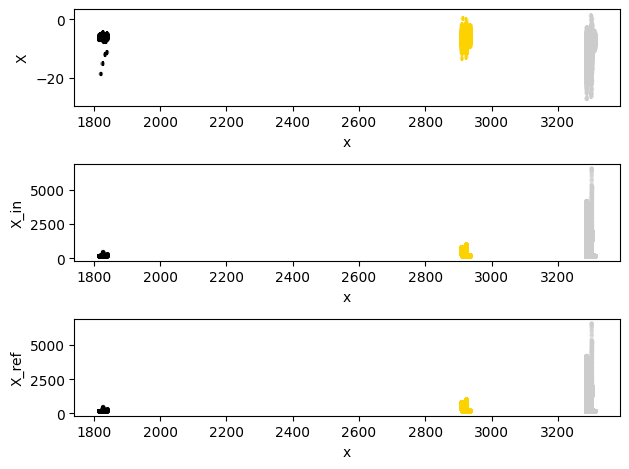

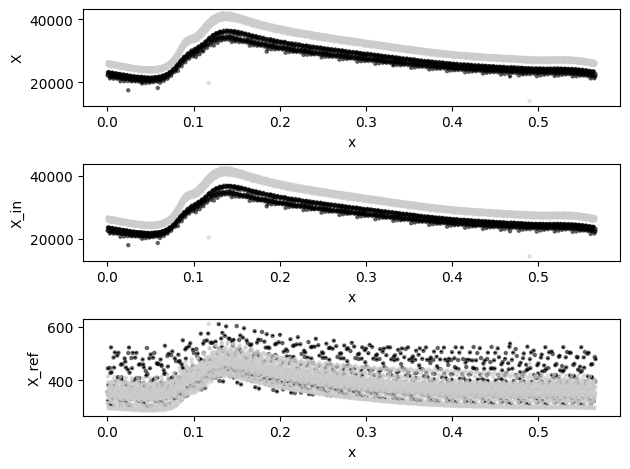

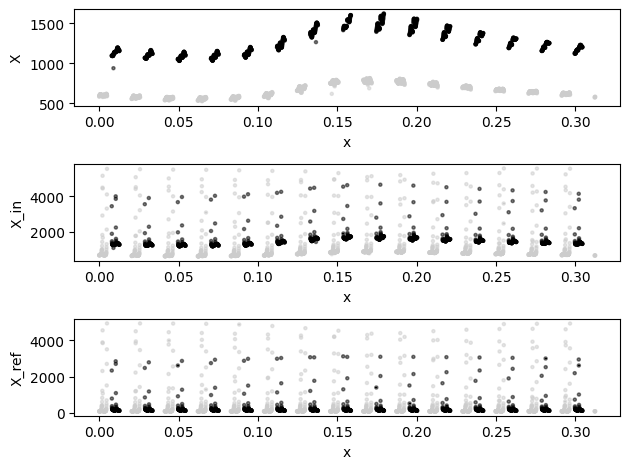

In [15]:
importlib.reload(aph)
#execute differential photometry
DPLC = aph.DifferentialPhotometryLC(
    n_jobs=-1,
    verbose=0,
)

# DPLC.fit(
#     X=lcs_targ, X_ref=lcs_bg,
#     X_e=lcs_targ_e, X_ref_e=lcs_bg_e,
#     strategy=None,
#     strategy_kwargs=None,
#     parallel_kwargs=dict(backend='threading')
# )

# lcs_dp, lcs_dp_e = DPLC.transform()

lcs_dp, lcs_dp_e = DPLC.fit_transform(
    X=lcs_targ, X_ref=lcs_bg,
    X_e=lcs_targ_e, X_ref_e=lcs_bg_e,
    fit_kwargs=dict(
        parallel_kwargs={'backend':'threading'}
    )
)

for idx in range(0, len(lcs_dp)):
# for idx in range(0, 1):
    lc_dp = lcs_dp[idx]
    fig, axs = DPLC.plot_result(
        X=lcs_dp[idx], X_e=lcs_dp_e[idx],
        X_in=lcs_targ[idx], X_in_e=lcs_targ_e[idx],
        X_ref=lcs_bg[idx], X_ref_e=lcs_bg_e[idx],
        x_vals=times[idx]%df_targets['period'][idx],
        sctr_kwargs=dict(c=sectors[idx], alpha=0.5, s=5),
        errorbar_kwargs=dict(alpha=1)
    )
plt.show()

### Frame-Wise Differential Photometry

lcs_bg[0].shape=(1282, 1, 1)
lcs_bg_e[0].shape=(1282, 1, 1)


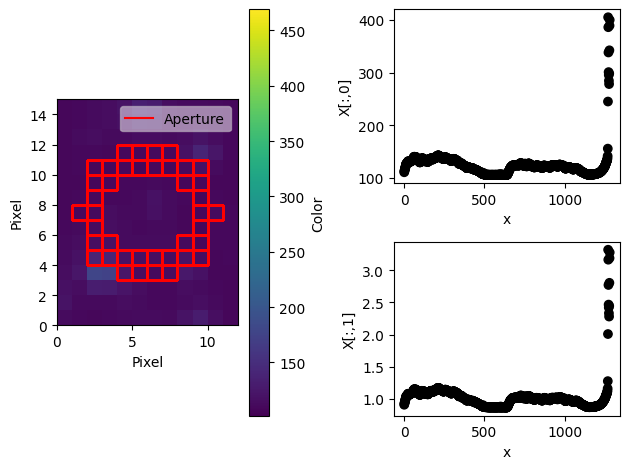

In [16]:
importlib.reload(aph)
#apply aperture photometry

APH = aph.AperturePhotometry(n_jobs=1, verbose=0)


lcs_bg, lcs_bg_e, aps_bg = APH.fit_transform(
    X=tpfs, X_e=tpfs_e,
    # #sum sky-ring
    # fit_kwargs=dict(
    #     apertures=[ap_bg]*len(tpfs),
    #     reduce_func=None,
    # ),
    #median sky-ring
    fit_kwargs=dict(
        apertures=[ap_bg*np.isfinite(ap_bg).sum()]*len(tpfs),   
        reduce_func=lambda x, x_e, axis: (np.nanmedian(x, axis=axis), np.nanmax(x_e, axis=axis)),
        # reduce_func=lambda x, x_e, axis: (3*np.nanmean(x, axis=axis) - 2*np.nanmedian(x, axis=axis), np.nanmax(x_e, axis=axis)),
    ),
)

#plotting
##remove nan to enable setting alpha
ap2plot_bg = aps_bg[0].copy()
ap2plot_bg[np.isnan(ap2plot_bg)] = 0
fig, axs, anim = APH.plot_result(
    X=lcs_bg[0], X_e=lcs_bg_e[0],
    X_in=tpfs[0],
    aperture=ap2plot_bg,
    animate=False
)


#expand to 3d to be castable with image
lcs_bg      = [lc[:,0].flatten().reshape(-1,1,1) for lc in lcs_bg]  
lcs_bg_e    = [lc[:,0].flatten().reshape(-1,1,1) for lc in lcs_bg_e]    

print(f'{lcs_bg[0].shape=}')
print(f'{lcs_bg_e[0].shape=}')



/home/lukas/venvs/thesisCS/lib/python3.10/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


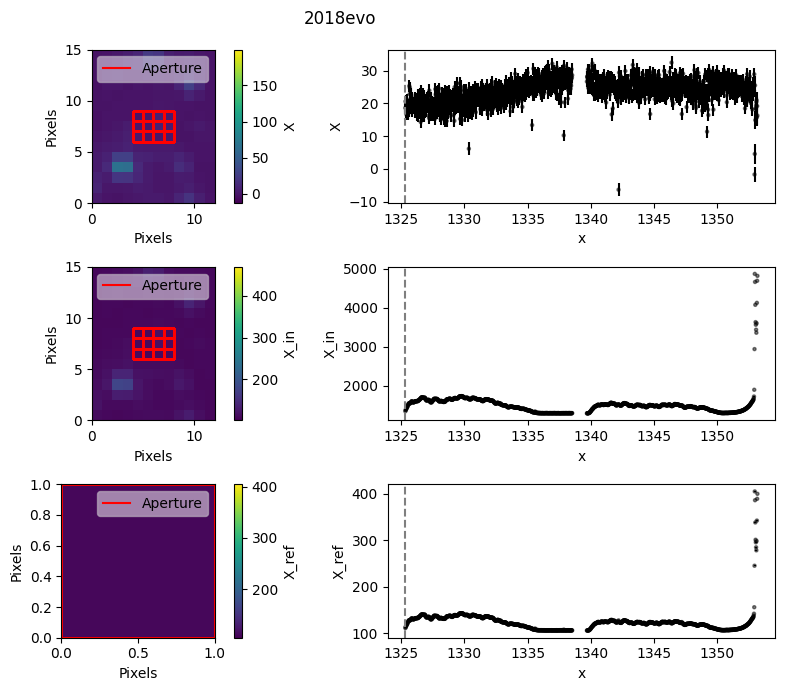

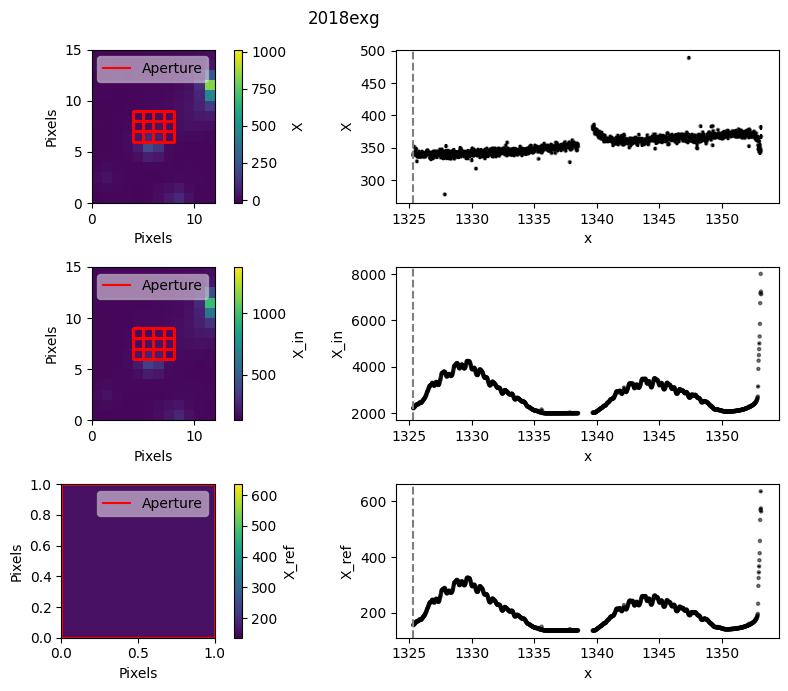

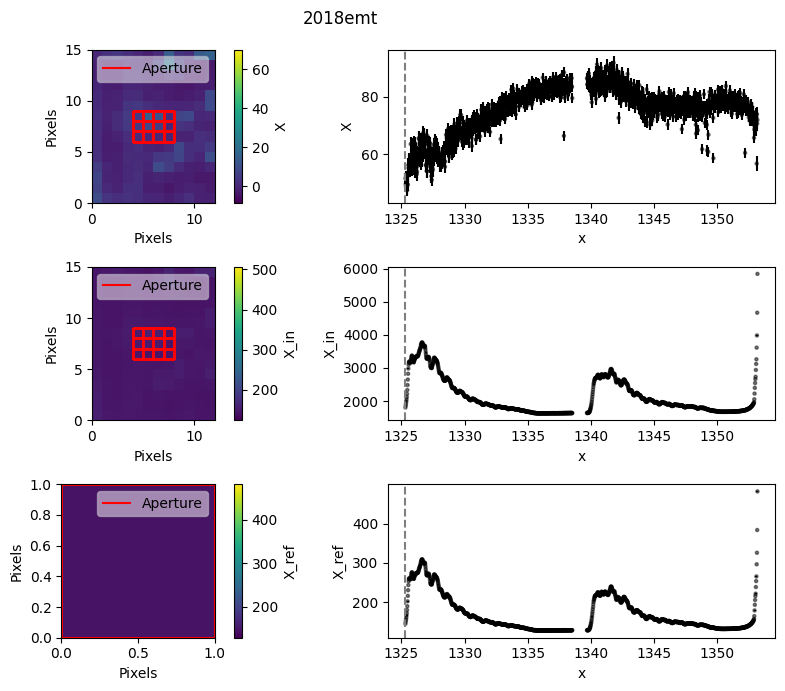

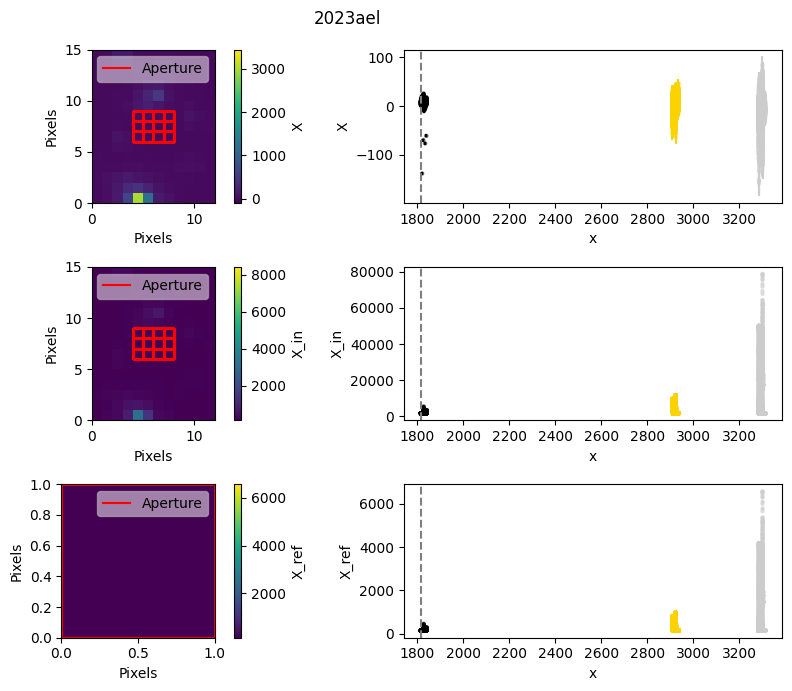

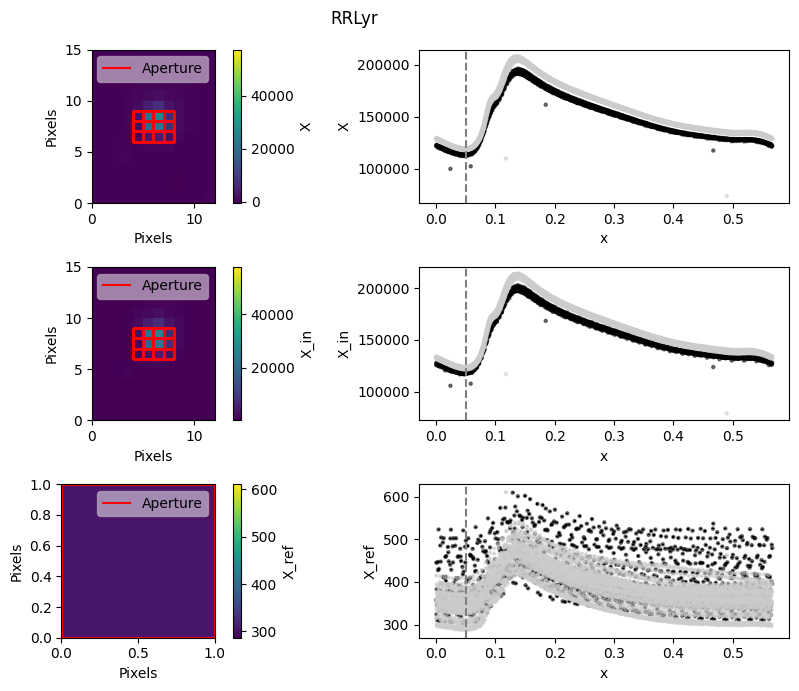

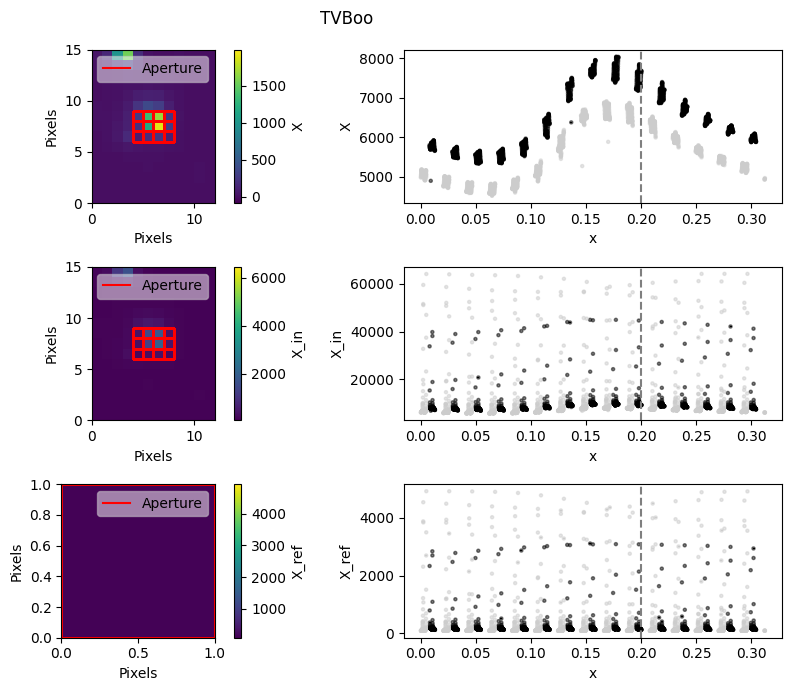

In [17]:
importlib.reload(aph)

#execute differential photometry
DPI = aph.DifferentialPhotometryImage(
    n_jobs=1,
    verbose=1,
)
DPI.fit(
    X=tpfs, y=None, X_ref=lcs_bg,
    X_e=tpfs_e, X_ref_e=lcs_bg_e,
    strategy='previous',
    n_jobs=None,
    verbose=None,
    strategy_kwargs=None,
    parallel_kwargs=None,
)
X_dp, X_dp_e = DPI.transform(X=tpfs, y=None)


#plot result
for idx in range(0,len(X_dp)):
# for idx in range(2,3):
    #make sure X_dp matches shape requirements (relevant if no X_ref found and therefore `strategy="previous"` was used)
    if len(X_dp[idx]) != len(tpfs[idx]):
        X_dp_correction = np.empty((1,*X_dp[idx].shape[1:]))
        X_dp_correction[:,:,:] = np.nan
        X_dp[idx] = np.append(X_dp[idx], X_dp_correction, axis=0)

    fig = plt.figure(figsize=(9,7))
    fig.suptitle(df_targets['name'][idx])
    fig, axs, anim = DPI.plot_result(
        X=X_dp[idx], y=None,X_e=X_dp_e[idx],
        X_in=tpfs[idx], X_in_e=tpfs_e[idx],
        X_ref=lcs_bg[idx], X_ref_e=lcs_bg_e[idx],
        x_vals=times[idx]%df_targets['period'][idx],
        aperture=2,
        fig=fig,
        animate=True,
        verbose=None,
        pcolormesh_kwargs=None,
        sctr_kwargs=dict(c=sectors[idx], alpha=0.5, s=5),
        errorbar_kwargs=dict(alpha=1),
        func_animation_kwargs=dict(frames=np.arange(0, X_dp[idx].shape[0], 50))
    )

    # if anim is not None: anim.save(f'./temp_{df_targets["name"][idx]}_diffphot.gif')



## Median of Surrounding TPFs (Frame-Wise Differential Photometry)
* similar approach to BRITE

tpfs_patched_i.shape=(1282, 3, 3, 5, 4)
tpfs_patched_i_e.shape=(1282, 3, 3, 5, 4)
tpfs_patched_i.shape=(1282, 3, 3, 5, 4)
tpfs_patched_i_e.shape=(1282, 3, 3, 5, 4)
tpfs_patched_i.shape=(1282, 3, 3, 5, 4)
tpfs_patched_i_e.shape=(1282, 3, 3, 5, 4)
tpfs_patched_i.shape=(22655, 3, 3, 5, 4)
tpfs_patched_i_e.shape=(22655, 3, 3, 5, 4)
tpfs_patched_i.shape=(5168, 3, 3, 5, 4)
tpfs_patched_i_e.shape=(5168, 3, 3, 5, 4)
tpfs_patched_i.shape=(2359, 3, 3, 5, 4)
tpfs_patched_i_e.shape=(2359, 3, 3, 5, 4)


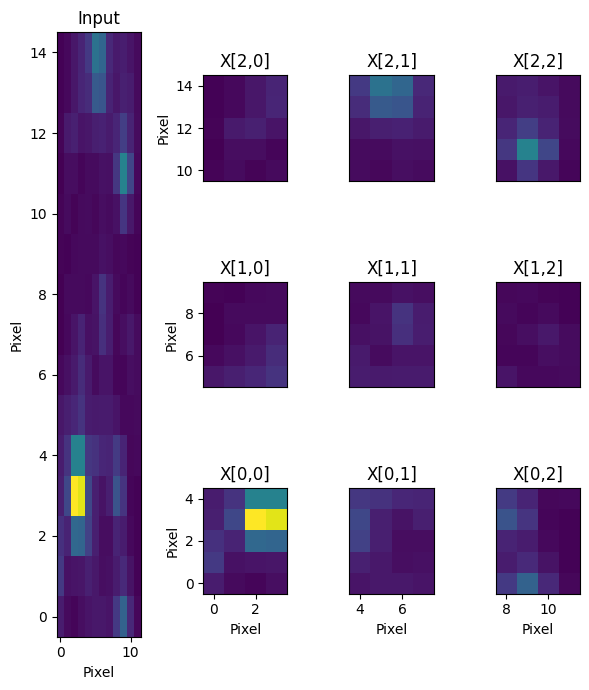

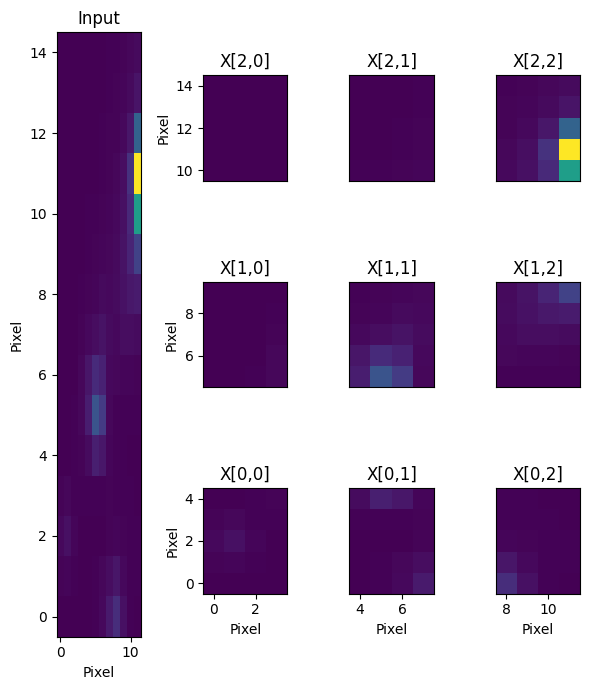

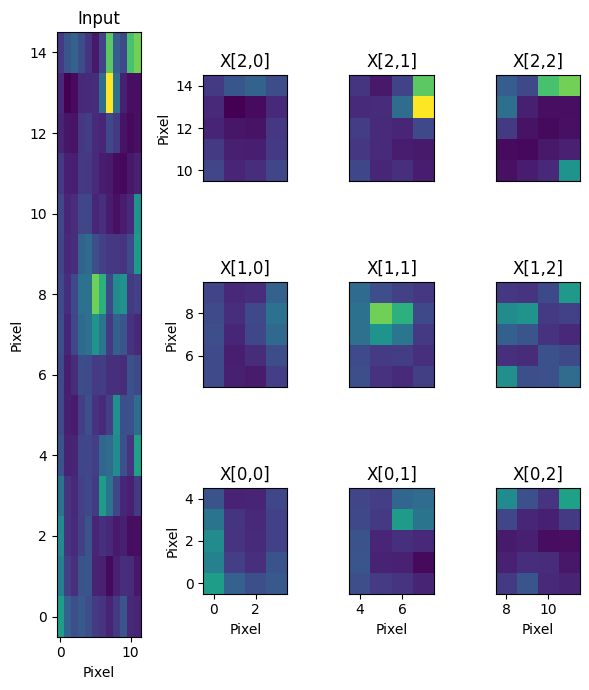

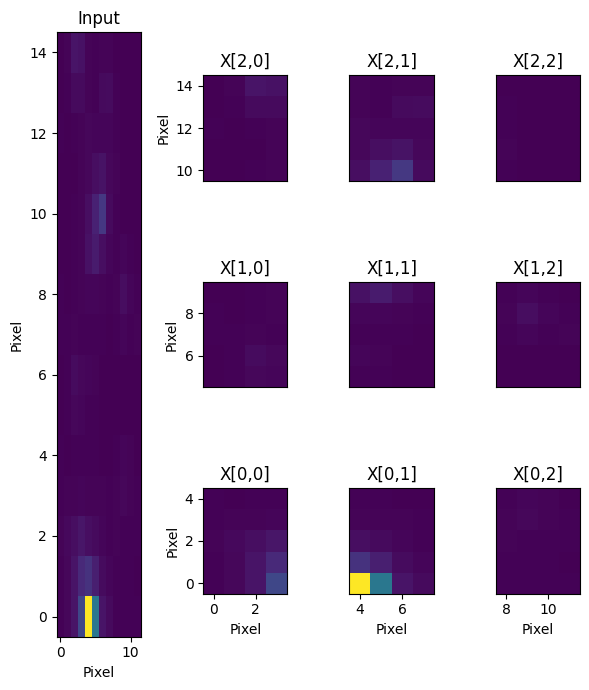

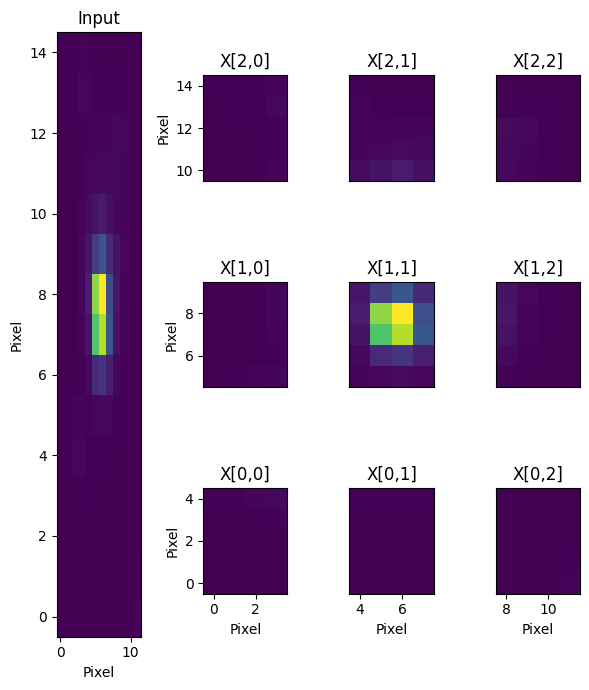

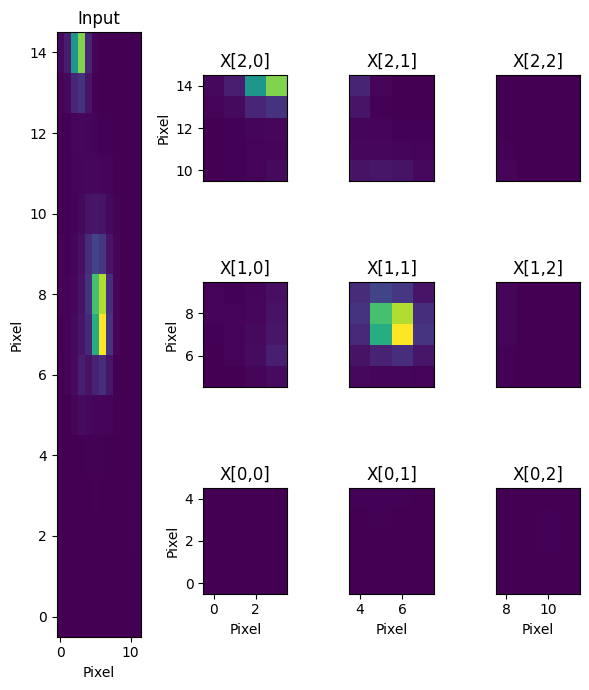

In [18]:
importlib.reload(aph)

tpf2process = 2 #select target to process

tpfs_patched = []
tpfs_patched_e = []
for i in range(0,len(tpfs)):
# for i in range(0,1):

    #patch current tpf series
    ##observations
    I2P = aph.Images2Patches(
        xpatches=3, ypatches=3,
        # xpatches=4, ypatches=5,
        verbose=0,
    )
    I2P.fit(
        X=tpfs[i], y=None,
        xpatches=None,
        ypatches=None,
        verbose=None,
    )
    tpfs_patched_i = I2P.transform()
    tpfs_patched.append(tpfs_patched_i) #store for further processing/visualization
    print(f'{tpfs_patched_i.shape=}')

    ##errors
    I2P.fit(
        X=tpfs_e[i], y=None,
        xpatches=None,
        ypatches=None,
        verbose=None,
    )
    tpfs_patched_i_e = I2P.transform()
    tpfs_patched_e.append(tpfs_patched_i_e) #store for further processing/visualization
    print(f'{tpfs_patched_i_e.shape=}')

    #plot
    fig = plt.figure(figsize=(6,7))
    fig, axs = I2P.plot_result(
        X=tpfs_patched_i[0], X_in=tpfs[i][0],
        # X=tpfs_patched_i_e[0], X_in=tpfs_e[i][0],
        fig=fig,
        pcolormesh_kwargs=dict(vmin=tpfs[i][0].min(), vmax=tpfs[i][0].max())
    )

    fig.tight_layout()
    # # axs[-1].set_aspect('equal')

plt.show()

In [19]:
#separate contaminating patches and science patch
print(f'{tpfs_patched[0].shape=}')
tpfs_sci = [tpfp_i[:,2,2,:,:] for tpfp_i in tpfs_patched]      #get center patch
tpfs_bg = [tpfp_i[:,::2,::2,:,:] for tpfp_i in tpfs_patched]   #get everything but center patch
tpfs_sci_e = [tpfp_i[:,2,2,:,:] for tpfp_i in tpfs_patched_e]      #get center patch
tpfs_bg_e = [tpfp_i[:,::2,::2,:,:] for tpfp_i in tpfs_patched_e]   #get everything but center patch

#get median contamination patch
tpfs_bg     = [np.nanmedian(tpfs_bg_i, axis=(1,2)) for tpfs_bg_i in tpfs_bg]
tpfs_bg_e   = [np.nanmax(tpfs_bg_i, axis=(1,2)) for tpfs_bg_i in tpfs_bg_e]     #worst possible outcome #TODO: rethink
print(f'{tpfs_sci[0].shape=}')
print(f'{tpfs_bg[0].shape=}')
print(f'{tpfs_sci_e[0].shape=}')
print(f'{tpfs_bg_e[0].shape=}')

tpfs_patched[0].shape=(1282, 3, 3, 5, 4)
tpfs_sci[0].shape=(1282, 5, 4)
tpfs_bg[0].shape=(1282, 5, 4)
tpfs_sci_e[0].shape=(1282, 5, 4)
tpfs_bg_e[0].shape=(1282, 5, 4)


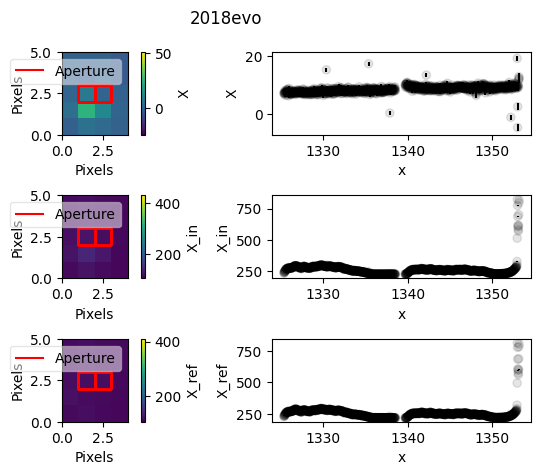

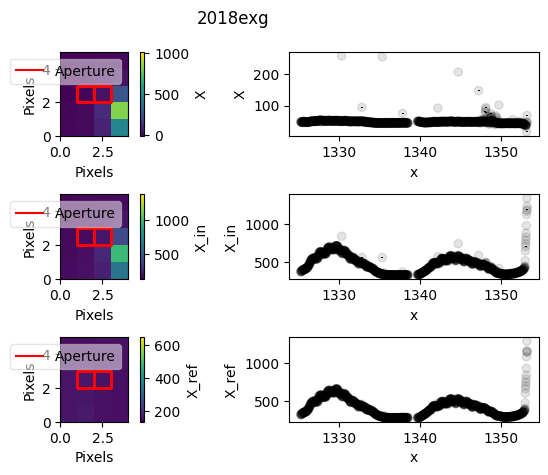

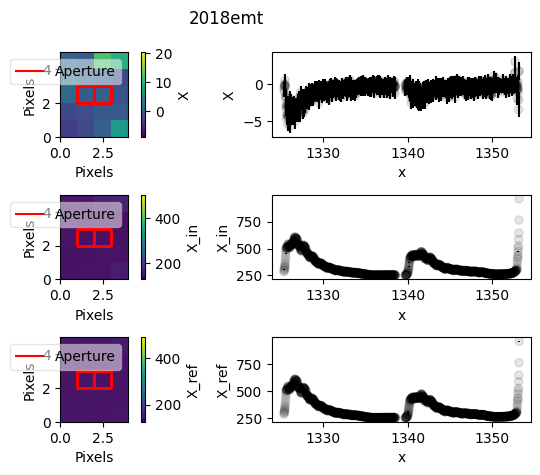

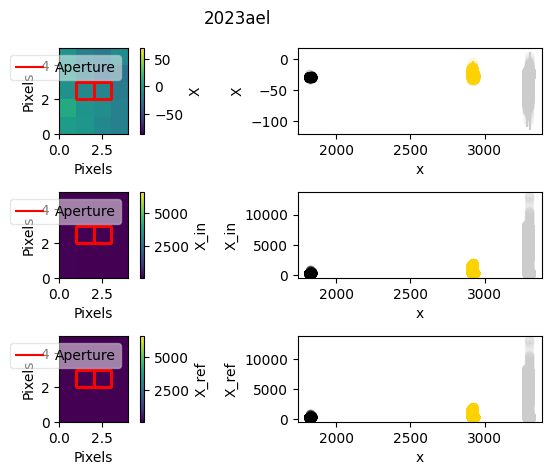

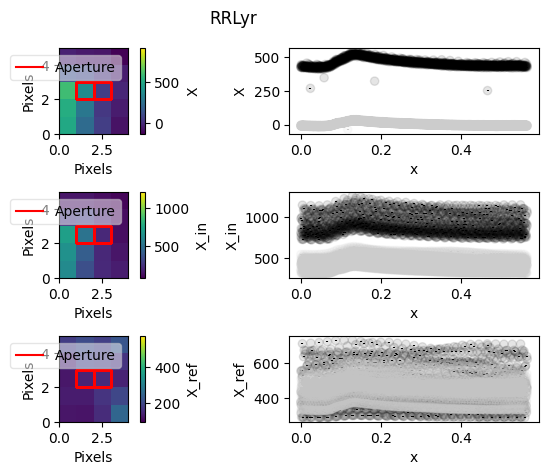

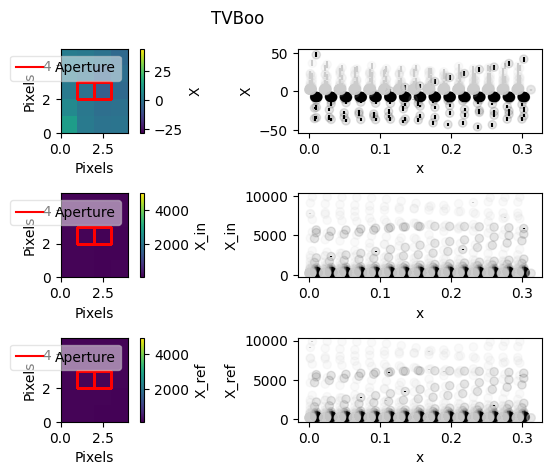

In [20]:
importlib.reload(aph)

# tpfs_bg_e = [np.random.randn(*tpfs_sci[0].shape)]

#execute differential photometry
DPI = aph.DifferentialPhotometryImage(
    n_jobs=1,
    verbose=1,
)

DPI.fit(
    X=tpfs_sci, X_ref=tpfs_bg,
    X_e=tpfs_sci_e, X_ref_e=tpfs_bg_e,
    strategy=None,
    # strategy='previous',
    n_jobs=None,
    verbose=None,
    parallel_kwargs=dict(backend='threading'),
    strategy_kwargs=None,
)
tpfs_dp, tpfs_dp_e = DPI.transform()

for i in range(0,len(tpfs_dp)):
# for i in range(0,1):
    fig, axs, anim = DPI.plot_result(
        X=tpfs_dp[i], X_e=tpfs_dp_e[i],
        X_in=tpfs_sci[i], X_in_e=tpfs_sci_e[i],
        X_ref=tpfs_bg[i], X_ref_e=tpfs_bg_e[i],
        x_vals=times[i]%df_targets['period'][i],
        aperture=1,
        fig=None,
        animate=False,
        verbose=None,
        pcolormesh_kwargs=None,
        sctr_kwargs=dict(c=sectors[i], alpha=0.1),
        func_animation_kwargs=None,
    )
    fig.suptitle(df_targets['name'][i])
    fig.tight_layout()

plt.show()